<a href="https://colab.research.google.com/github/mlelarge/dataflowr/blob/master/CEA_EDF_INRIA/03_convolution_digit_recognizer_full_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutions by examples

### Acknowledgement

Code from Sections 1 to 3 taken from [fastai: lesson 0](http://course.fast.ai/lessons/lesson0.html)

## 1. Preparations

In [0]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

In [0]:
import torch
import torchvision
from torchvision import models,transforms,datasets

Download MNIST data on disk and convert it to pytorch compatible formating.

```torchvision.datasets``` features support (download, formatting) for a collection of popular datasets. The list of available datasets in ```torchvision``` can be found [here](http://pytorch.org/docs/master/torchvision/datasets.html).

Note that the download is performed only once. The function will always check first if the data is already on disk.


In [3]:
root_dir = '/content/data/MNIST/'
torchvision.datasets.MNIST(root=root_dir,download=True)

0it [00:00, ?it/s]

9920512it [00:01, 9057548.29it/s]                            


Extracting /content/data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135832.73it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2566279.50it/s]                           
0it [00:00, ?it/s]

Extracting /content/data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51573.93it/s]            

Extracting /content/data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/data/MNIST/
    Split: Train

MNIST datasets consists of small images of hand-written digits. The images are grayscale and have size 28 x 28. There are 60,000 training images and 10,000 testing images.

In [0]:
train_set = torchvision.datasets.MNIST(root=root_dir, train=True, download=True)

Define and initialize a data loader for the MNIST data already downloaded on disk.

In [0]:
MNIST_dataset = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=1)

For the current notebook, since we are doing no training, we can format data as _numpy ndarrays_ which are easier to plot in matplotlib. The same operations can be easily performed on _pytorch Tensors_.

In [0]:
images = train_set.data.numpy().astype(np.float32)/255
labels = train_set.targets.numpy()

In [13]:
print(images.shape,labels.shape)

(60000, 28, 28) (60000,)


## 2. Data visualization

For convenience we define a few functions for formatting and plotting our image data

In [0]:
# plot multiple images
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

# plot a single image
def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

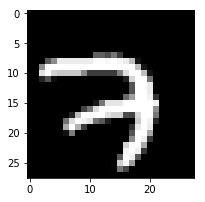

In [15]:
plot(images[5000])

In [16]:
labels[5000]

7

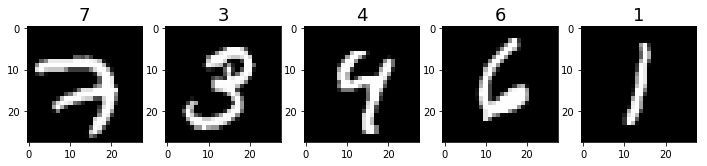

In [17]:
plots(images[5000:5005], titles=labels[5000:5005])

## 3. Filters and convolutions

Here is a simple 3x3 filter, ie a 3x3 matrix (see [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) for more examples)

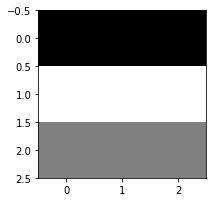

In [18]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

In [0]:
cross = np.zeros((28,28))
cross += np.eye(28)
for i in range(4):
    cross[12+i,:] = np.ones(28)
    cross[:,12+i] = np.ones(28)

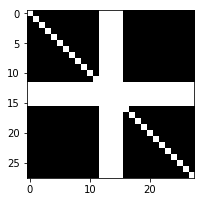

In [20]:
plot(cross)

In some fields, convolution or filtering can be better understood as _correlations_. 
In practice we slide the filter matrix over the image (a bigger matrix) always selecting patches from the image with the same size as the filter. We compute the dot product between the filter and the image patch and store the scalar response which reflects the degree of similarity/correlation between the filter and image patch.

In [0]:
from scipy.ndimage.filters import convolve, correlate

corr_cross = correlate(cross,top)

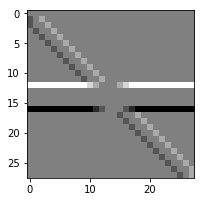

In [22]:
plot(corr_cross)

In [0]:
?correlate

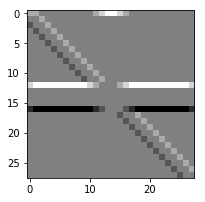

In [24]:
# to see the role of padding
corr_cross = correlate(cross,top, mode='constant')
plot(corr_cross)

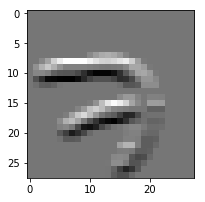

In [25]:
corrtop = correlate(images[5000], top)
plot(corrtop)

By rotating the filter with 90 degrees and calling the ```convolve``` function we get the same response as with the previously called ```correlate``` function.

In [26]:
np.rot90(top, 1)

array([[-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0]])

True

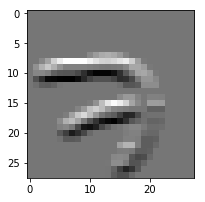

In [27]:
convtop = convolve(images[5000], np.rot90(top,2))
plot(convtop)
np.allclose(convtop, corrtop)

Let's generate a few more variants of our simple 3x3 filter

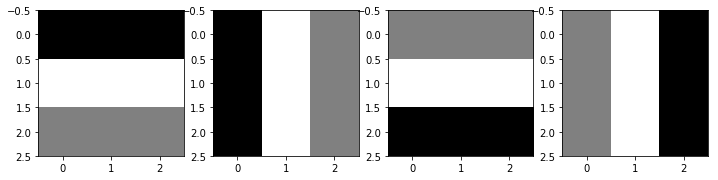

In [28]:
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)

We proceed similarly to generate a set of filters with a different behavior

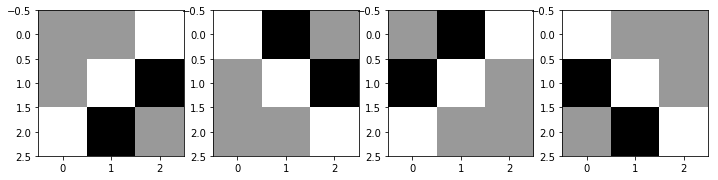

In [29]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

We can compose filters to obtain more complex patterns

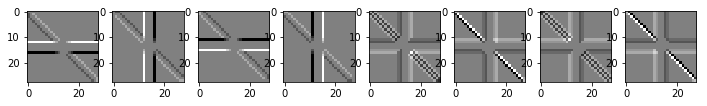

In [30]:
rots = straights + diags
corrs_cross = [correlate(cross, rot) for rot in rots]
plots(corrs_cross)

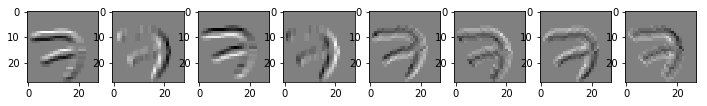

In [31]:
rots = straights + diags
corrs = [correlate(images[5000], rot) for rot in rots]
plots(corrs)

Next we illustrate the effect of downsampling.
We select the most basic downsampling technique: __max pooling__. We keep only the maximum value for sliding windows of size ```7x7```.
__Max pooling__ is a handy technique with a few useful perks:
- since it selects the maximum values it ensures invariance to translations
- reducing the size is helpful since data becomes more compact and easier to compare
- we will see later in this course that since max pooling reduces the size of our images, the operations performed later on in the network have bigger receptive field / concern a bigger patch in the input image and allow the discovery of higher level patterns.

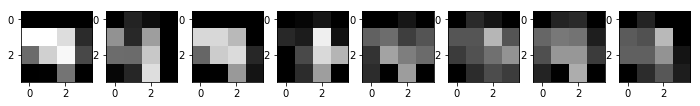

In [33]:
import skimage

from skimage.measure import block_reduce

def pool(im): return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

## 4. A simple classifier

In this section we will construct a basic classifier similar to k-nearest neighbors.
Our classifier will tell us whether a given image depicts a _one_ or an _eight_.

To this end we select a set of training images depicting _eights_ and _ones_, we convolve them with our set of filters, pool them and average them for each class and filter. We will thus obtain a set of _representative_ signatures for _eights_ and for _ones_. 
Given a new test image we compute its features by convolution and pooling with the same filters and then compare them with the _representative_ features. The class with the most _similar_ features is chosen as prediction.

We fetch all images from the _eight_ class and from the _one_ class.

In [0]:
n=len(images)

In [0]:
eights=[images[i] for i in range(n) if labels[i]==8]
ones=[images[i] for i in range(n) if labels[i]==1]

In [39]:
len(eights), len(ones)

(5851, 6742)

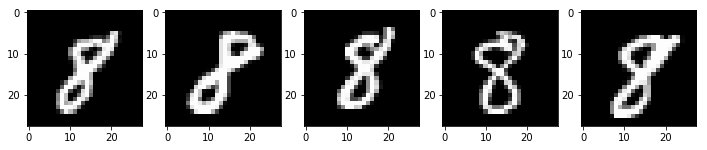

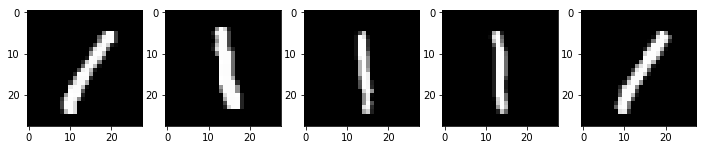

In [40]:
plots(eights[:5])
plots(ones[:5])

We keep the first 1000 digits for the test set.

In [0]:
raws8 =  np.mean(eights[1000:],axis=0)

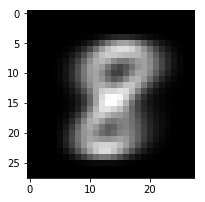

In [42]:
plot(raws8)

In [0]:
raws1 =  np.mean(ones[1000:],axis=0)

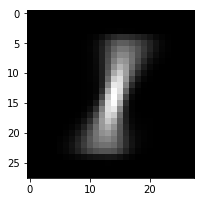

In [44]:
plot(raws1)

In [0]:
# sum of squared errors
def sse(a,b): return ((a-b)**2).sum()

def is8_raw_n2(im): return 1 if sse(im,raws1) > sse(im,raws8) else 0

In [46]:
[np.array([is8_raw_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[912, 27]

In [47]:
[np.array([(1-is8_raw_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[88, 973]

![precision recall](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/1024px-Precisionrecall.svg.png)

In [48]:
Precision_8 = 912/(912+27)
Recall_8 = 912/1000
Precision_1 = 973/(973+88)
Recall_1 = 973/1000

print('precision 8:', Precision_8, 'recall 8:', Recall_8)
print('precision 1:', Precision_1, 'recall 1:', Recall_1)
print('accuracy :', (Recall_1+Recall_8)/2)

precision 8: 0.9712460063897763 recall 8: 0.912
precision 1: 0.9170593779453345 recall 1: 0.973
accuracy : 0.9425


We now build a classifier with convolutions.

We keep 1000 images of _eight_ for the test set and use the remaining ones for the training: we convolve them with our bank of filters, perform max pooling on the responses and store them in ```pool8```.

In [0]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights[1000:]]) for rot in rots]

In [50]:
len(pool8), pool8[0].shape

(8, (4851, 4, 4))

We plot the result of the first filter+pooling on the first 5 _eights_ in our set. 

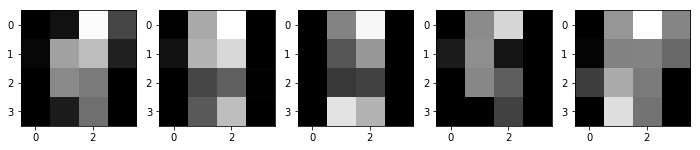

In [51]:
plots(pool8[0][0:5])

For the 3 first _eightts_ in our set, we plot the result of the 8 filters+pooling

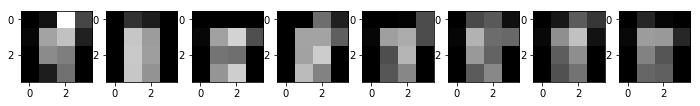

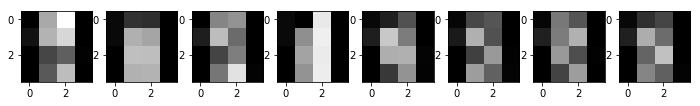

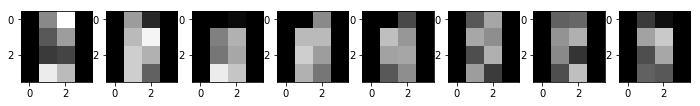

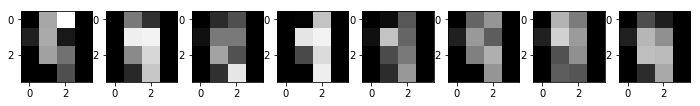

In [52]:
plots([pool8[i][0] for i in range(8)])
plots([pool8[i][1] for i in range(8)])
plots([pool8[i][2] for i in range(8)])
plots([pool8[i][3] for i in range(8)])

We normalize the data in order to smoothen activations and bring them to similar ranges of values

In [0]:
def normalize(arr): return (arr-arr.mean())/arr.std()

Next we compute the average _eight_ by averaging all responses for each filter from _rots_.

In [0]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])
filts8 = normalize(filts8)

We should obtain a set of canonical _eights_ responses for each filter.

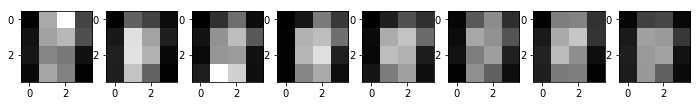

In [55]:
plots(filts8)

We proceed similarly with training samples from the _one_ class and plot the canonical _ones_.

In [0]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones[1000:]]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

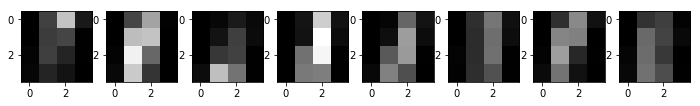

In [57]:
plots(filts1)

Do you notice any differences between ```filts8``` and ```filts1```? Which ones?

We define a function that correlates a given image with all filters from ```rots``` and max pools the responses.

In [0]:
def pool_corr(im): return np.array([pool(correlate(im, rot)) for rot in rots])

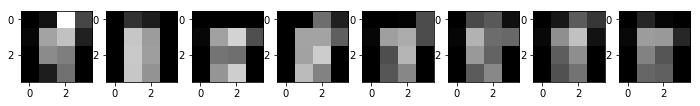

In [59]:
plots(pool_corr(eights[1000]))

True

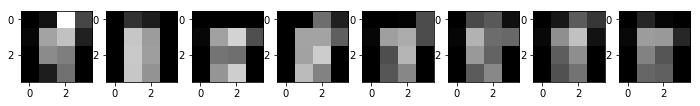

In [60]:
#check 
plots([pool8[i][0] for i in range(8)])
np.allclose(pool_corr(eights[1000]),[pool8[i][0] for i in range(8)])

In [0]:
# function used for a voting based classifier that will indicate which one of the 
# two classes is most likely given the sse distances
# n2 comes from norm2
# is8_n2 returns 1 if it thinks it's an eight and 0 otherwise
def is8_n2(im): return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8) else 0

We perform a check to see if our function actually works. We correlate the an image of _eight_ with ```filts8``` and ```filts1```. It should give smaller error for the _eights_.

In [62]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(103.67323, 126.09805)

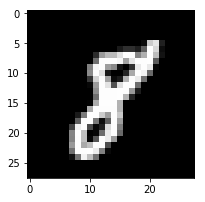

In [63]:
plot(eights[0])

We now test our classifier on the 1000 images of _eights_ and 1000 images of _ones_

In [64]:
[np.array([is8_n2(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[969, 37]

It said in 969 cases it is an _eight_ and 37 case it is a _one_

Let's now test the opposite, ie it's not an _eight_ , it's not a _one_

In [65]:
[np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[31, 963]

In [66]:
Precision_8 = 969/(969+37)
Recall_8 = 969/1000
Precision_1 = 963/(963+31)
Recall_1 = 963/1000

print('precision 8:', Precision_8, 'recall 8:', Recall_8)
print('precision 1:', Precision_1, 'recall 1:', Recall_1)
print('accuracy :', (Recall_1+Recall_8)/2)

precision 8: 0.963220675944334 recall 8: 0.969
precision 1: 0.9688128772635815 recall 1: 0.963
accuracy : 0.966


We improved the accuracy while reducing the embedding size from a $28\times 28 = 784$ vector to a $4\times 4\times 8 = 128$ vector.

Let's test the our simple classifier with a new distance

In [0]:
# sum of absolute differences
def n1(a,b): return (np.fabs(a-b)).sum()

# is8_n1 returns 1 if it thinks it's an eight and 0 otherwise
def is8_n1(im): return 1 if n1(pool_corr(im),filts1) > n1(pool_corr(im),filts8) else 0

In [68]:
[np.array([is8_n1(im) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[941, 31]

In [69]:
[np.array([(1-is8_n1(im)) for im in ims]).sum() for ims in [eights[:1000],ones[:1000]]]

[59, 969]

We have successfully built a classifier for _eights_ and _ones_ using features extract with a bank of pre-defined features and a set of training samples. We will improved it during the next lectures.

#### Questions
- What are the advantages of this method?
- What are the weak points of this method?
- How can we improve it?

### A few useful ressources about convolutions:
1. [Convolution animations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)
2. [Interactive image kernels](http://setosa.io/ev/image-kernels/)
3. [CS231n: Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/)

## 5. Practicals: improving classification with Convolutional Neural Net

You will now build a neural net that will learn the weights of the filters.

The first layer of your network will be a convolutional layer with $8$ filters of size $3\times 3$ as we did above. This will produce a (once flatten) a vector of size $128 = 3\times 3\times 8$. From this vector, you need to predict if the corresponding input is a $1$ or a $8$. So you are back to a classification problem or logistic regression, i.e. from there you can apply the solution of previous homework!

You need to fill the code written below to construct your CNN. You will need to look for documentation about [torch.nn](https://pytorch.org/docs/stable/nn.html) in the Pytorch doc.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    def __init__(self):
        super(classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.fc = nn.Linear(in_features=128, out_features=2)
        
    def forward(self,x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=7, stride=7)
        x = x.view(-1, 4*4*8)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [0]:
conv_class = classifier()

Your code should work fine on a batch of 3 images.

In [73]:
batch_3images = train_set.data[0:2].type(torch.FloatTensor).resize_(3, 1, 28, 28)
conv_class(batch_3images)

tensor([[ 0.0000e+00, -5.0499e+01],
        [ 0.0000e+00, -3.1515e+01],
        [-1.5361e+30,  0.0000e+00]], grad_fn=<LogSoftmaxBackward>)

The following lines of code implement a data loader for the train set and the test set. No modification is needed.

In [0]:
bs = 64

l8 = np.array(0)
eights_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l8.astype(np.int64))] for e in eights]
l1 = np.array(1)
ones_dataset = [[torch.from_numpy(e.astype(np.float32)).unsqueeze(0), torch.from_numpy(l1.astype(np.int64))] for e in ones]
train_dataset = eights_dataset[1000:] + ones_dataset[1000:]
test_dataset = eights_dataset[:1000] + ones_dataset[:1000]

train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=bs, shuffle=True)

You need now to code the training loop. Store the loss and accuracy for each epoch.

In [0]:
def train(model,data_loader,loss_fn,optimizer,n_epochs=1):
    model.train(True)
    loss_train = np.zeros(n_epochs)
    acc_train = np.zeros(n_epochs)
    for epoch_num in range(n_epochs):
        running_corrects = 0.0
        running_loss = 0.0
        size = 0

        for data in data_loader:
            inputs, labels = data
            bs = labels.size(0)
                
            outputs = model(inputs)
            loss = loss_fn(outputs,labels)       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs,1)
            running_corrects += torch.sum(preds == labels.data.type(torch.LongTensor))
            running_loss += loss.data
            size += bs
        epoch_loss = running_loss.item() / size
        epoch_acc = running_corrects.item() / size
        loss_train[epoch_num] = epoch_loss
        acc_train[epoch_num] = epoch_acc
        print('Train - Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        test(model,test_loader)
    return loss_train, acc_train

In [82]:
conv_class = classifier()
loss_fn = nn.NLLLoss()
learning_rate = 1e-3
#optimizer_cl = torch.optim.SGD(conv_class.parameters(), lr=learning_rate)
optimizer_cl = torch.optim.Adam(conv_class.parameters(), lr=learning_rate)
l_t, a_t = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0057 Acc: 0.9194
Test - Loss: 0.0023 Acc: 0.9780
Train - Loss: 0.0014 Acc: 0.9809
Test - Loss: 0.0010 Acc: 0.9885
Train - Loss: 0.0008 Acc: 0.9886
Test - Loss: 0.0007 Acc: 0.9885
Train - Loss: 0.0006 Acc: 0.9907
Test - Loss: 0.0006 Acc: 0.9890
Train - Loss: 0.0005 Acc: 0.9922
Test - Loss: 0.0006 Acc: 0.9905
Train - Loss: 0.0004 Acc: 0.9932
Test - Loss: 0.0005 Acc: 0.9905
Train - Loss: 0.0003 Acc: 0.9939
Test - Loss: 0.0005 Acc: 0.9910
Train - Loss: 0.0003 Acc: 0.9943
Test - Loss: 0.0004 Acc: 0.9905
Train - Loss: 0.0003 Acc: 0.9950
Test - Loss: 0.0004 Acc: 0.9905
Train - Loss: 0.0003 Acc: 0.9951
Test - Loss: 0.0004 Acc: 0.9925


Let's learn for 10 more epochs

In [83]:
l_t1, a_t1 = train(conv_class,train_loader,loss_fn,optimizer_cl,n_epochs = 10)

Train - Loss: 0.0002 Acc: 0.9954
Test - Loss: 0.0003 Acc: 0.9920
Train - Loss: 0.0002 Acc: 0.9953
Test - Loss: 0.0003 Acc: 0.9925
Train - Loss: 0.0002 Acc: 0.9961
Test - Loss: 0.0003 Acc: 0.9935
Train - Loss: 0.0002 Acc: 0.9958
Test - Loss: 0.0003 Acc: 0.9925
Train - Loss: 0.0002 Acc: 0.9957
Test - Loss: 0.0003 Acc: 0.9925
Train - Loss: 0.0002 Acc: 0.9963
Test - Loss: 0.0004 Acc: 0.9915
Train - Loss: 0.0002 Acc: 0.9967
Test - Loss: 0.0003 Acc: 0.9935
Train - Loss: 0.0002 Acc: 0.9968
Test - Loss: 0.0003 Acc: 0.9930
Train - Loss: 0.0002 Acc: 0.9971
Test - Loss: 0.0002 Acc: 0.9945
Train - Loss: 0.0002 Acc: 0.9971
Test - Loss: 0.0003 Acc: 0.9935


Our network seems to learn but we now need to check its accuracy on the test set.

In [0]:
def test(model,data_loader):
    model.train(False)

    running_corrects = 0.0
    running_loss = 0.0
    size = 0

    for data in data_loader:
        inputs, labels = data
            
        bs = labels.size(0)
        #print(bs)
                
        outputs = model(inputs)
            #print(outputs)
        classes = labels == 1
            #print(classes)
        loss = loss_fn(outputs,classes.type(torch.LongTensor)) 
        _,preds = torch.max(outputs,1)
            #print(preds)
            #print(classes)
        running_corrects += torch.sum(preds == classes.data.type(torch.LongTensor))
        running_loss += loss.data
        size += bs

    print('Test - Loss: {:.4f} Acc: {:.4f}'.format(running_loss / size, running_corrects.item() / size))

In [84]:
test(conv_class,test_loader)

Test - Loss: 0.0003 Acc: 0.9935


Change the optimizer to Adam.

How many parameters did your network learn?

You can see them as follows:

In [85]:
for m in conv_class.children():
    print('weights :', m.weight.data)
    print('bias :', m.bias.data)

weights : tensor([[[[-0.5901, -0.1806,  0.4880],
          [-0.4562,  0.4061,  0.3312],
          [ 0.2772,  0.3811,  0.4771]]],


        [[[ 0.2956,  0.2065, -0.5052],
          [ 0.0025,  0.3835, -0.2636],
          [-0.3954,  0.4933,  0.2982]]],


        [[[ 0.6946,  0.5701, -0.3938],
          [ 0.5309,  0.4773, -0.8774],
          [ 0.3900,  0.3320, -0.3544]]],


        [[[ 0.5948,  0.4121, -0.6861],
          [ 0.2634,  0.2125, -0.3930],
          [ 0.4531,  0.5398, -0.3691]]],


        [[[-0.6465, -0.5841, -0.1572],
          [-0.0644,  0.0801,  0.5414],
          [ 0.5621,  0.5311, -0.0345]]],


        [[[ 0.2485, -0.3964, -0.1535],
          [ 0.2760,  0.0076, -0.3907],
          [ 0.2631,  0.0778,  0.6549]]],


        [[[ 0.4246,  0.3110,  0.4876],
          [ 0.1608,  0.0720,  0.1918],
          [-0.4012, -0.8792,  0.0813]]],


        [[[ 0.1009, -0.2489, -0.1433],
          [ 0.2837, -0.5069,  0.0806],
          [ 0.4072,  0.1486,  0.3629]]]])
bias : tensor([-0.2230,

In [0]:
for m in conv_class.children():
    T_w = m.weight.data.numpy()
    T_b = m.bias.data.numpy()
    break

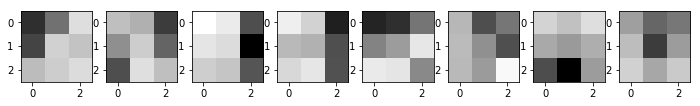

In [87]:
plots([T_w[i][0] for i in range(8)])

In [88]:
T_b

array([-0.2230461 , -0.454333  , -0.06900841,  0.356765  ,  0.10276112,
       -0.3308682 , -0.52058285, -0.5856613 ], dtype=float32)